In [1]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def build_model(input_shape, kernel_size, pool_size, activation, n_classes):
    
    model = Sequential()
    
    ##### CNN layer 1
    model.add(Conv2D(filters=64, kernel_size=kernel_size, input_shape=input_shape))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.1))

    
    ##### CNN layer 2
    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(Activation(activation))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.1))

    
    model.add(Flatten())
    #model.add(Dropout(rate=0.1))
    
    model.add(Dense(16, activation=activation))
    #model.add(Dropout(rate=0.1))

    model.add(Dense(n_classes, activation='softmax'))

    return model

In [3]:
##### create a data generator
datagen_test = ImageDataGenerator(rescale=1./255)

datagen_train = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.05,
                             zoom_range=0.05,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [4]:
##### load and iterate training, validation, test dataset
train_gen = datagen_train.flow_from_directory('../images/train/', 
                                        target_size=(300, 300), 
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        save_to_dir=None,
                                        color_mode = 'rgb', 
                                        shuffle=True)

val_gen = datagen_test.flow_from_directory('../images/validation/', 
                                      target_size=(300, 300), 
                                      class_mode='categorical', 
                                      batch_size=32, 
                                      save_to_dir=None, 
                                      color_mode = 'rgb', 
                                      shuffle=True)

test_gen = datagen_test.flow_from_directory('../images/test/', 
                                       target_size=(300, 300), 
                                       class_mode='categorical', 
                                       batch_size=32, 
                                       save_to_dir=None,
                                       color_mode = 'rgb', 
                                       shuffle=True)

Found 10832 images belonging to 3 classes.
Found 1547 images belonging to 3 classes.
Found 3095 images belonging to 3 classes.


In [7]:
input_shape = (300,300,3)
kernel_size = (3, 3)
pool_size = (2, 2)
activation='relu'
n_classes = 3
n_epoch = 2

learning_rate = [0.0001]

##### build model
model = build_model(input_shape, kernel_size, pool_size, activation, n_classes)
model.summary()

callback = ModelCheckpoint(filepath='../models/model00.h5', monitor='val_accuracy', mode='max', save_best_only=True)

train_result=[]
test_result=[]
for rate in learning_rate:
    
    print("learning_rate:",rate)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=rate), 
                  metrics=['accuracy', 'Precision', keras.metrics.Recall()])

    history = model.fit_generator(train_gen, ### model.fit()
                        epochs=n_epoch, 
                        validation_data=val_gen) 
                        ### steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                        ### validation_steps = TotalvalidationSamples / ValidationBatchSize
    
    score_train = model.evaluate_generator(train_gen, steps=200) ### model.evaluate()
    score_test = model.evaluate_generator(test_gen, steps=200)
    
    train_result.append(score_train)
    test_result.append(score_test)
    
    print("train model score:", score_train)
    print("test model score:", score_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 298, 298, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0

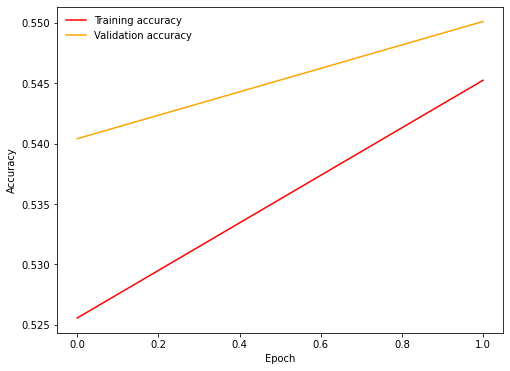

In [8]:
##### graphs
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['accuracy'], color='red')
ax.plot(history.history['val_accuracy'], color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'], frameon=False)
plt.show()

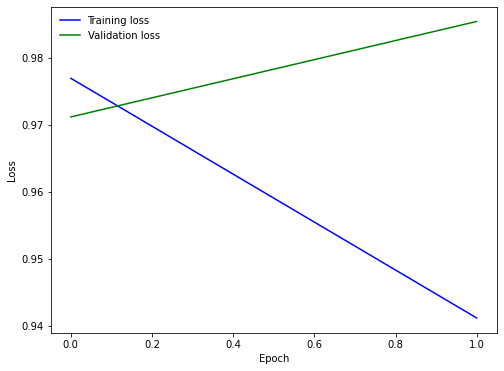

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], color='blue')
ax.plot(history.history['val_loss'], color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], frameon=False)
plt.show()

In [3]:
##### load model
#model.save('../model/model4.h5')
#model = models.load_model('../model/model4.h5')
#model.summary()